# DL development pipeline

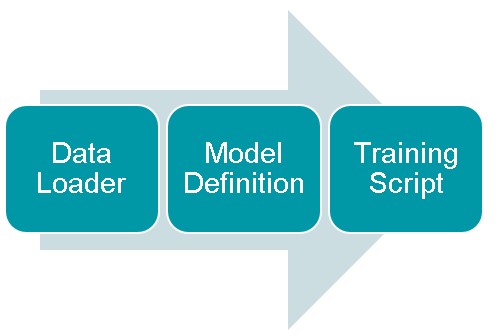

```
# Example from https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
class CIFAR10Sequence(Sequence): 케라스의 시퀀스를 사용

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)
```



*   `__len__` : Number of batch in the Sequence. 한 에폭에 몇 개의 배치가 있는지
*   `__getitem__` : Returns a complete batch.하나의 배치를 생성해주는 메소드
*   `on_epoch_end` (optional) : Modifies dataset between epochs. 에폭이 끝날때마다 부르는 콜백함수





In [1]:
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

In [2]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, 
                 fold, image_size, mode='train',
                 shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path) #데이터 불러오기
        
        #데이터 프레임에서 필요한 데이터만 남기기
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold] #해당 폴드가 아닌 모든 데이터
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold] #해당 폴드인 모든 데이터
        
        self.on_epoch_end()#학습 시작할때도 한번씩 shuffle
        
    def __len__(self): #한 에폭에 몇개의 배치가 있는지 값을 리턴
        return math.ceil(len(self.df) / self.batch_size) #올림 : ceil
        
    def __getitem__(self, idx): #몇번째 배치를 주어줌
        strt = idx * self.batch_size #첫번째 인덱스
        fin = (idx + 1) * self.batch_size #마지막 인덱스
        data = self.df.iloc[strt:fin] #주어진 인덱스에 대한 배치의 모든 인덱스가 남음
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data): #데이터를 읽어서 반환
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#BGR을 RGB로
            
            image = cv2.resize(image, (self.image_size, self.image_size)) #이미지마다 크기가 다르기때문에 resize필수!
            #rescaling
            image = image / 255. #image_size는 인자로 받음
            
            
            label = int(r['species']) - 1 #이진분류로 값을 0 or 1로 만들기 위함
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

    #callback함수 : 매 epoch(학습)이 끝날때마다 호출
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [3]:
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size=9, 
    csv_path=csv_path,
    fold=1,
    image_size=256,
    mode='train',
    shuffle=True
)

In [4]:
print(len(train_generator)) #len 메소드 확인

654


In [5]:
(654 * 9)

5886

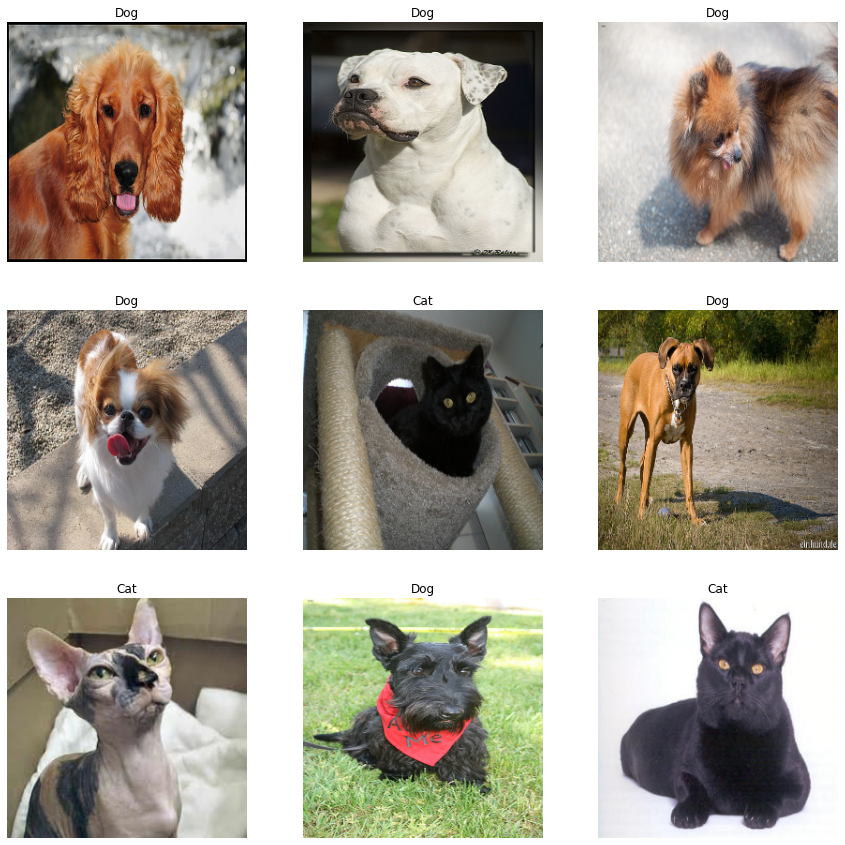

In [6]:
class_name = ['Cat', 'Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
    
    break